In [1]:
import pandas as pd
import neurokit2 as nk
import plotly.graph_objects as go
import plotly.io as pio
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.signal import butter, filtfilt
# 1. Load the physiological data from the CSV file
subject_id = 19
video_id = 0

out_path = '/work/abslab/emognition_2023_challenge/data/'

def plot_emg(emg_signals,save_path):
    #plt.figure(figsize=(12,8))
    print(sum(emg_signals['EMG_Onsets']))
    if sum(emg_signals['EMG_Onsets'])<1:
        emg_signals.iloc[0,-2]=1
        emg_signals.iloc[1,-1]=1
        nk.emg_plot(emg_signals, sampling_rate=1000)
        emg_signals.iloc[0,-2]=0
        emg_signals.iloc[1,-1]=0
    else:
        nk.emg_plot(emg_signals, sampling_rate=1000)
    plt.savefig(save_path)
    
def plot_nk(signal_df,
            plotting_function,
            backup_signal,
            save_path,
            static=True
           ):
    try:
        if static:
            plotting_function(signal_df,sampling_rate=1000)
            plt.savefig(save_path+'.png')
        else:
            plotly_plot = plotting_function(signal_df,static=static,sampling_rate=1000)
            pio.write_html(plotly_plot, file=save_path+'.html')
    except:
        print(backup_signal)
        plt.figure(figsize=(12,8))
        plt.plot(signal_df[backup_signal])
        plt.savefig(save_path+'.png')
        
def low_pass_filter(df, column_name, sampling_rate=1000, cutoff_frequency=1):
    # Calculate the Nyquist frequency
    nyquist_freq = 0.5 * sampling_rate

    # Normalize the cutoff frequency with respect to the Nyquist frequency
    normalized_cutoff = cutoff_frequency / nyquist_freq

    # Design the Butterworth low-pass filter
    b, a = butter(N=2, Wn=normalized_cutoff, btype='low')

    # Apply the filter to the signal using filtfilt
    filtered_signal = filtfilt(b, a, df[column_name])

    return filtered_signal
    
def process_and_save_data(file_name):
    # 2. Process the photoplethysmography (PPG) signal
    data = pd.read_csv(file_name)
    # 2. Process the photoplethysmography (PPG) signal
    bvp_signals, info = nk.ppg_process(data["bvp"], sampling_rate=1000)
    # 3. Process the electrocardiography (ECG) signal
    ecg_signals, info = nk.ecg_process(data["ecg"], sampling_rate=1000)
    # 4. Process the electromyography (EMG) signals
    emg_coru_signals,info = nk.emg_process(data["emg_coru"], sampling_rate=1000)
    emg_trap_signals,info = nk.emg_process(data["emg_trap"], sampling_rate=1000)
    emg_zygo_signals,info = nk.emg_process(data["emg_zygo"], sampling_rate=1000)
    # plot_emg(emg_coru_signals,file_name[:-4]+'emg_coru.png')
    # plot_emg(emg_trap_signals,file_name[:-4]+'emg_trap.png')
    # plot_emg(emg_zygo_signals,file_name[:-4]+'emg_zygo.png')
#     plt.savefig("emg_trap_plot.png")

#     plt.figure()
#     nk.emg_plot(emg_zygo_signals, sampling_rate=1000)
#     plt.savefig("emg_zygo_plot.png")
    # Define the muscle names
    muscle_coru = "corrugator_"
    muscle_trap = "trapezius_"
    muscle_zygo = "zygomaticus_"

    # Append the muscle names to the column names in the EMG data frames
    emg_coru_signals.columns = emg_coru_signals.columns.map(lambda x: muscle_coru + x)
    emg_trap_signals.columns = emg_trap_signals.columns.map(lambda x: muscle_trap + x)
    emg_zygo_signals.columns = emg_zygo_signals.columns.map(lambda x: muscle_zygo + x)

     # 5. Process the electrodermal activity (EDA) signal
    eda_signals, info = nk.eda_process(data["gsr"], sampling_rate=1000)

    # 6. Process the respiration (RSP) signal
    rsp_signals, info = nk.rsp_process(data["rsp"], sampling_rate=1000)
    # 8. Merge the processed signals
    # return [bvp_signals, ecg_signals, emg_coru_signals,
    #                                emg_trap_signals, emg_zygo_signals, eda_signals, rsp_signals, data[["skt"]]]
    data["skt"]=low_pass_filter(data, "skt")
    processed_signals = pd.concat([bvp_signals, ecg_signals, 
                                   emg_coru_signals,
                                   emg_trap_signals, 
                                   emg_zygo_signals, 
                                   eda_signals, rsp_signals, data["skt"]], axis=1)
    processed_signals['sub_num']=scenario_file.split('_')[-3]
    processed_signals['vid_num']=scenario_file.split('_')[-1][:-4]

    # Preprocessing and processing steps (same as before)# 9. Save the processed data to a new CSV file
    processed_file_name = file_name[:-4]+"_processed.csv"
    processed_signals.to_csv(processed_file_name, index=False)
    
    # 10. Generate plots and save them as interactive Plotly figures
    #plt.figure(figsize=(12,8))
    #nk.ecg_plot(ecg_signals, sampling_rate=1000)
    # plot_nk(ecg_signals,nk.ecg_plot,'ECG_Clean',file_name[:-4]+"ecg_plot")
    # plot_nk(eda_signals,nk.eda_plot,'EDA_Clean',file_name[:-4]+"eda_plot",static=False)
    # plot_nk(rsp_signals,nk.rsp_plot, 'RSP_Clean',file_name[:-4]+"rsp_plot",static=False)
    # plot_nk(bvp_signals,nk.ppg_plot, 'PPG_Clean',file_name[:-4]+"ppg_plot",static=False)
    # plt.show()


scenario_3_files = glob.glob('/work/abslab/emognition_2023_challenge/data/scenario_3/*/*/phys*/*[0-9].csv')
error_list = []
for scenario_file in scenario_3_files:
    try:
        process_and_save_data(scenario_file)
    except:
        print(scenario_file)
        error_list.append(scenario_file)
pd.DataFrame({'erro_files':error_list}).to_csv('scenario_3_errors.csv')

scenario_4_files = glob.glob('/work/abslab/emognition_2023_challenge/data/scenario_4/*/*/phys*/*[0-9].csv')
error_list = []
for scenario_file in scenario_4_files:
    try:
        process_and_save_data(scenario_file)
    except:
        print(scenario_file)
        error_list.append(scenario_file)
pd.DataFrame({'erro_files':error_list}).to_csv('scenario_4_errors.csv')
        
    

/home/mcveigh.k/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mcveigh.k/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mcveigh.k/.local/lib/python3.9/site-packages/neurokit2/events/events_find.py:116: NeuroKitWarning: No events found. Check your event_channel or adjust 'threshold' or 'keep' arguments.
  warn(
/home/mcveigh.k/.local/lib/python3.9/site-packages/neurokit2/events/events_find.py:116: NeuroKitWarning: No events found. Check your event_channel or adjust 'threshold' or 'keep' arguments.
  warn(
/home/mcveigh.k/.local/lib/python3.9/site-packages/neurokit2/events/events_find.py:116: NeuroKitWarning: No events found. Check your event_channel or adjust 'threshold' or 'keep' arguments.
  warn(
/home/mcveigh.k/.local/lib/python3.9/site-packages/neurokit

In [ ]:
# scenario_2_files = glob.glob('/work/abslab/emognition_2023_challenge/data/scenario_3/*/*/phys*/*[0-9].csv')
# error_list = []
# for scenario_file in scenario_3_files:
#     try:
#         process_and_save_data(scenario_file)
#     except:
#         print(scenario_file)
#         error_list.append(scenario_file)
# pd.DataFrame({'erro_files':error_list}).to_csv('scenario_3_errors.csv')

# scenario_2_files = glob.glob('/work/abslab/emognition_2023_challenge/data/scenario_4/*/*/phys*/*[0-9].csv')
# error_list = []
# for scenario_file in scenario_3_files:
#     try:
#         process_and_save_data(scenario_file)
#     except:
#         print(scenario_file)
#         error_list.append(scenario_file)
# pd.DataFrame({'erro_files':error_list}).to_csv('scenario_4_errors.csv')

In [2]:
import pandas as pd
import neurokit2 as nk
import plotly.graph_objects as go
import plotly.io as pio
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import zscore

def custom_downsample(df, factor, retain_columns):
    # Initialize an empty DataFrame for the downsampled data
    downsampled_df = pd.DataFrame()

    for column in df.columns:
        if column in retain_columns:
            # Retain the ones in the specified columns
            downsampled_data = df[column].rolling(window=factor, min_periods=1).max()
        else:
            # Downsample by taking the mean of every 'factor' rows
            downsampled_data = df[column].rolling(window=factor, min_periods=1).mean()

        # Select every 'factor'-th row
        downsampled_data = downsampled_data.iloc[::factor,]

        # Add the downsampled column to the new DataFrame
        downsampled_df[column] = downsampled_data

    return downsampled_df

def add_peak_height_colum(df,peak_col,signal_col):
    peak_heights = df.loc[df[peak_col]==1][signal_col]
    return peak_heights.index.values, peak_heights

columns_of_interest = [
    'PPG_Clean', 'PPG_Rate', 'PPG_Peaks',
    'ECG_Rate','ECG_Quality',
    'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks','SCR_Height', 'SCR_Amplitude',
    'RSP_Amplitude', 'RSP_Rate',
    'corrugator_EMG_Clean',
    'corrugator_EMG_Amplitude', 'corrugator_EMG_Activity',
    'corrugator_EMG_Onsets', 'corrugator_EMG_Offsets', 'trapezius_EMG_Raw',
    'trapezius_EMG_Clean', 'trapezius_EMG_Amplitude',
    'trapezius_EMG_Activity', 'trapezius_EMG_Onsets',
    'trapezius_EMG_Offsets', 'zygomaticus_EMG_Raw', 'zygomaticus_EMG_Clean',
    'zygomaticus_EMG_Amplitude', 'zygomaticus_EMG_Activity',
    'zygomaticus_EMG_Onsets', 'zygomaticus_EMG_Offsets',
    'RSP_RVT', 'RSP_Phase', 'RSP_Phase_Completion',
    'RSP_Symmetry_PeakTrough', 'RSP_Symmetry_RiseDecay'
]

columns_that_are_mostly_zeros = ['PPG_Peak_Height','SCR_Peaks','SCR_Height','SCR_Amplitude',
    'zygomaticus_EMG_Onsets', 'zygomaticus_EMG_Activity',
    'zygomaticus_EMG_Offsets', 'trapezius_EMG_Activity','trapezius_EMG_Onsets',
    'corrugator_EMG_Activity',
    'corrugator_EMG_Onsets', 'corrugator_EMG_Offsets',
    'trapezius_EMG_Offsets']


# code to start creating features

In [126]:
processed_file[:-4]+'_20hz.csv'

'/work/abslab/emognition_2023_challenge/data/scenario_1/test/physiology/sub_11_vid_1_processed_20hz.csv'

In [3]:
# plt.plot(df.loc[df['PPG_Peaks']==1]['PPG_Clean'].values)
# df['PPG_Peak_Height']=0
# ppg_peak_heights = df.loc[df['PPG_Peaks']==1]['PPG_Clean']
# df.iloc[ppg_peak_heights.index.values,df.columns.get_loc('PPG_Peak_Height')]=ppg_peak_heights
# plt.plot(df['PPG_Peak_Height'].values[:20000])


# 3. Calculate rolling means 
# 4. add affective features



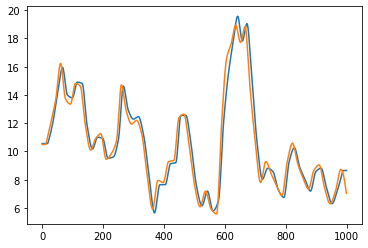

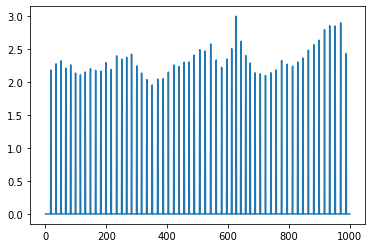

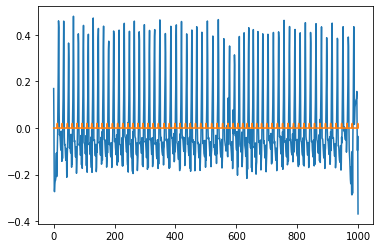

In [122]:
df = pd.read_csv('test_feature_df.csv')
plt.plot(df['PPG_Rate']-60)
plt.plot(df['ECG_Rate']-60)
plt.show()
plt.plot(df['PPG_Peak_Height'])
plt.show()
plt.plot(df['ECG_Clean'][:5000])
plt.plot(df['ECG_R_Peaks'][:5000])


<AxesSubplot:>

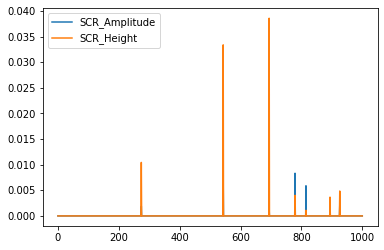

In [123]:
df[['SCR_Amplitude','SCR_Height']].plot()

In [69]:

df.columns



Index(['PPG_Raw', 'PPG_Clean', 'PPG_Rate', 'PPG_Peaks', 'ECG_Raw', 'ECG_Clean',
       'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks', 'ECG_P_Peaks', 'ECG_P_Onsets',
       'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets',
       'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets',
       'ECG_Phase_Atrial', 'ECG_Phase_Completion_Atrial',
       'ECG_Phase_Ventricular', 'ECG_Phase_Completion_Ventricular',
       'corrugator_EMG_Raw', 'corrugator_EMG_Clean',
       'corrugator_EMG_Amplitude', 'corrugator_EMG_Activity',
       'corrugator_EMG_Onsets', 'corrugator_EMG_Offsets', 'trapezius_EMG_Raw',
       'trapezius_EMG_Clean', 'trapezius_EMG_Amplitude',
       'trapezius_EMG_Activity', 'trapezius_EMG_Onsets',
       'trapezius_EMG_Offsets', 'zygomaticus_EMG_Raw', 'zygomaticus_EMG_Clean',
       'zygomaticus_EMG_Amplitude', 'zygomaticus_EMG_Activity',
       'zygomaticus_EMG_Onsets', 'zygomaticus_EMG_Offsets', 'EDA_Raw',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'S

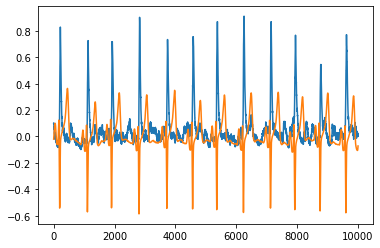

In [84]:
plt.plot((df['trapezius_EMG_Raw'][:10000]-7.5)/10)
#plt.plot(df['corrugator_EMG_Clean'],alpha=.5)
plt.plot(df['ECG_Clean'][:10000])
#plt.plot(eda_signals['EDA_Tonic'])

[ 1079  1871  2774  3690  4535  5328  6205  7094  7892  8724  9570 10415
 11161 11997 12861 13629 14458 15309 16153 16911 17742 18584 19413 20156
 20980 21830 22667 23422 24261 25117 25968 26722 27560 28397 29255 30044
 30818 31641 32471 33279 34011 34806 35626 36457 37233 38084 38979 39870
 40654 41497 42365 43211 43954 44769 45600 46424 47170 48000 48848 49725]


ZeroDivisionError: division by zero

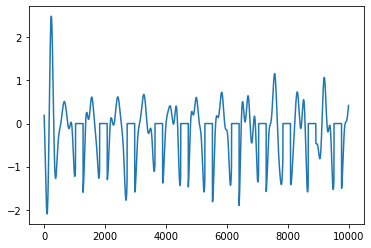

In [86]:
import numpy as np
import pandas as pd
import scipy.signal
from biosppy.signals.ecg import christov_segmenter as qrs_detect
from biosppy.signals.ecg import gamboa_segmenter as qrs_detect

def bandpass_filter(emg_signal, low_frequency, high_frequency, sampling_rate, order=4):
    nyquist_frequency = 0.5 * sampling_rate
    low = low_frequency / nyquist_frequency
    high = high_frequency / nyquist_frequency
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    filtered_signal = scipy.signal.filtfilt(b, a, emg_signal)
    return filtered_signal

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size), 'same') / window_size

def ecg_artifact_removal(emg_signal, rpeaks):
    # Detect QRS complexes using the Pan-Tompkins algorithm
    print(rpeaks)
    # Remove ECG artifacts
    corrected_emg = np.copy(emg_signal)
    for rpeak in rpeaks:
        window_start = max(0, rpeak - 50)
        window_end = min(len(emg_signal), rpeak + 200)
        corrected_emg[window_start:window_end] = 0

    return corrected_emg

corrected_signal = ecg_artifact_removal(filtered_signal, df[df['ECG_R_Peaks']==1].index.values)
plt.plot(corrected_signal[:10000])
0/0# Load your data
# df = pd.read_csv("your_emg_data.csv")  # Uncomment this line if loading data from a CSV file
df = pd.read_csv('/work/abslab/emognition_2023_challenge/data/scenario_1/test/physiology/sub_1_vid_11_processed.csv')
# Example DataFrame with EMG data


# Parameters
sampling_rate = 1000
low_frequency = 2
high_frequency = 5
filter_order = 4
window_size = 500

# Step 1: Filtering
filtered_signal = bandpass_filter(df['trapezius_EMG_Raw'], low_frequency, high_frequency, sampling_rate, order=filter_order)

# Step 2: Artifact removal (if required) - not included here, as it depends on the specific data and artifacts
# Step 2: ECG Artifact Removal
corrected_signal = ecg_artifact_removal(filtered_signal, df[df['ECG_R_Peaks']==1].index.values)
rectified_signal = np.abs(corrected_signal)

# Step 4: Smoothing
smoothed_signal = moving_average(rectified_signal, window_size)

# Step 5: Normalization
normalized_signal = (smoothed_signal - np.mean(smoothed_signal)) / np.std(smoothed_signal)

# Step 6: Add the preprocessed EMG signal to the DataFrame
df['EMG_Preprocessed'] = normalized_signal

plt.plot(normalized_signal)
rolling_window_size=1000
# Step 7: Rolling window feature extraction
rolling_window = df['EMG_Preprocessed'].rolling(window=rolling_window_size)

df['Mean'] = rolling_window.mean()
# df['Median'] = rolling_window.median()
# df['Standard_Deviation'] = rolling_window.std()
# df['Variance'] = rolling_window.var()
# df['Minimum'] = rolling_window.min()
# df['Maximum'] = rolling_window.max()
# df['Range'] = df['Maximum'] - df['Minimum']
df['RMS'] = rolling_window.apply(lambda x: np.sqrt(np.mean(x**2)))
plt.plot(df['Mean'])

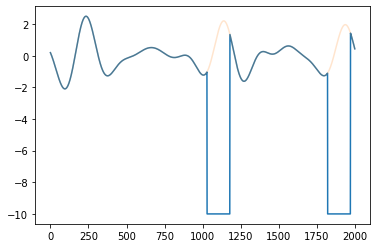

In [85]:
plt.plot(corrected_signal[:2000])
plt.plot(filtered_signal[:2000],alpha=.2)

In [92]:
import numpy as np
import pandas as pd
import scipy.signal
import padasip as pa

def bandpass_filter(emg_signal, low_frequency, high_frequency, sampling_rate, order=4):
    nyquist_frequency = 0.5 * sampling_rate
    low = low_frequency / nyquist_frequency
    high = high_frequency / nyquist_frequency
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    filtered_signal = scipy.signal.filtfilt(b, a, emg_signal)
    return filtered_signal

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size), 'same') / window_size

def ecg_artifact_removal_lms(emg_signal, ecg_signal, filter_length=10, mu=0.01):
    lms_filter = pa.filters.FilterLMS(n=filter_length, mu=mu, w="random")
    corrected_emg = lms_filter.run(emg_signal, ecg_signal)[0]
    return corrected_emg

# Load your data
# df = pd.read_csv("your_emg_data.csv")  # Uncomment this line if loading data from a CSV file

# # Example DataFrame with EMG and ECG data
# data = {'EMG': np.random.randn(10000), 'ECG': np.random.randn(10000)}
# df = pd.DataFrame(data)

# Parameters
sampling_rate = 1000
low_frequency = 20
high_frequency = 450
filter_order = 4
window_size = 50
rolling_window_size = 5000

# Step 1: Filtering
filtered_signal = bandpass_filter(df['trapezius_EMG_Raw'], low_frequency, high_frequency, sampling_rate, order=filter_order)

# Step 2: ECG Artifact Removal using LMS adaptive filtering
corrected_signal = ecg_artifact_removal_lms(filtered_signal, df['ECG_Clean'].values)

# Step 3: Rectification
rectified_signal = np.abs(corrected_signal)

# Step 4: Smoothing
smoothed_signal = moving_average(rectified_signal, window_size)

# Step 5: Normalization
normalized_signal = (smoothed_signal - np.mean(smoothed_signal)) / np.std(smoothed_signal)

# Step 6: Add the preprocessed EMG signal to the DataFrame
df['EMG_Preprocessed'] = normalized_signal

# Step 7: Rolling window feature extraction
rolling_window = df['EMG_Preprocessed'].rolling(window=rolling_window_size)

df['Mean'] = rolling_window.mean()
df['Median'] = rolling_window.median()
df['Standard_Deviation'] = rolling_window.std()
df['Variance'] = rolling_window.var()
df['Minimum'] = rolling_window.min()
df['Maximum'] = rolling_window.max()
df['Range'] = df['Maximum'] - df['Minimum']
df['RMS'] = rolling_window.apply(lambda x: np.sqrt(np.mean(x**2)))

print(df)


TypeError: object of type 'numpy.float64' has no len()

In [87]:
!pip install padasip

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for padasip: filename=padasip-1.2.2-py3-none-any.whl size=51667 sha256=1adb0e60d8a036034d9239c743f697728f5d42c92909951d79255b25c31d8963
  Stored in directory: /home/mcveigh.k/.cache/pip/wheels/91/2f/1d/db4c59fa9aac73f3256da883ef74d619bc48fcea6294163c4b
Successfully built padasip


In [93]:
lms_filter = pa.filters.FilterLMS(n=10, mu=.01, w="random")
lms_filter.run?

Signature: lms_filter.run(d, x)
Docstring:
This function filters multiple samples in a row.

**Args:**

* `d` : desired value (1 dimensional array)

* `x` : input matrix (2-dimensional array). Rows are samples,
  columns are input arrays.

**Returns:**

* `y` : output value (1 dimensional array).
  The size corresponds with the desired value.

* `e` : filter error for every sample (1 dimensional array).
  The size corresponds with the desired value.

* `w` : history of all weights (2 dimensional array).
  Every row is set of the weights for given sample.
File:      ~/.local/lib/python3.9/site-packages/padasip/filters/base_filter.py
Type:      method


In [94]:
pa.filters.FilterLMS?

Init signature: pa.filters.FilterLMS(n, mu, w='random')
Docstring:      This class represents an adaptive LMS filter.
Init docstring:
This class represents an generic adaptive filter.

**Args:**

* `n` : length of filter (integer) - how many input is input array
  (row of input matrix)

**Kwargs:**

* `mu` : learning rate (float). Also known as step size. If it is too slow,
  the filter may have bad performance. If it is too high,
  the filter will be unstable. The default value can be unstable
  for ill-conditioned input data.

* `w` : initial weights of filter. Possible values are:

    * array with initial weights (1 dimensional array) of filter size

    * "random" : create random weights

    * "zeros" : create zero value weights
File:           ~/.local/lib/python3.9/site-packages/padasip/filters/lms.py
Type:           type
Subclasses:     
